Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [210]:
from random import random, seed
import random
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from itertools import accumulate
from sklearn.cluster import KMeans


from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [211]:
UNIVERSE_SIZE = 1000
NUM_SETS = 100
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(NUM_SETS * DENSITY)]))

In [212]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [213]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()


def fitness(solution, valid, cost):
    """Evaluate the fitness of the solution."""
    if not valid(solution):
        return float('inf') 
    
    return 1 / (1 + cost(solution))

## Have Fun!

In [214]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(33723.17739337305))

In [215]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(20400.575710469828))

In [216]:
#My code

"""
Main ideas:
I avoided starting from a random solution, because that will have negatively impacted the time 
I created 3 semy-greedy methods to find the most interesting solutions (not the optimal ones, it can be seen because they dont check the cost of the solution, buto only the coverage (least vovered ones), distribution of the sets and the ones that add the most elements for more coverage )    
I added tweaking, temperature and cooling rate to avoid getting stuck in local minimum. The knn groupes similar interesting sets to esplore together.


Diversity greedy start
Purpose: Builds an initial solution by selecting sets that maximize the coverage of new, previously uncovered elements.
Rationale: A diverse starting solution can give a better foundation for optimization, as it ensures high initial coverage.


Least Covered greedy start
Purpose: Builds a solution by prioritizing sets that cover the least-covered elements (elements that appear in fewer sets).
Rationale: This approach ensures that rarer elements are covered early, balancing the coverage.


Random Constrained greedy start
Purpose: Visualizes the progress of both the current solution's cost and the best solution's cost over the iterations.
Rationale: Helps to track and understand the algorithm's performance during the optimization process.




Tweak function
it's objective is to generates a neighboring solution by flipping one or more sets (from selected to not selected and vice versa). It adds randomness in the search process.

Multiple flips: Introduces variation, increasing the chance of escaping local minima.
Improvement attempts: If the solution is valid, it randomly swaps sets to search for better coverage or lower cost.    



simulated annealing
I used a temperature and cooling rate to find an optimal solution by iteratively tweaking the current solution and gradually reducing the search randomness (temperature).
Temperature and cooling rate: The algorithm explores more widely at high temperatures but narrows the search as the temperature decreases. Even if a tweak increases the cost, it can be accepted with a certain probability based on the temperature, helping to avoid local minima.
Early stopping: The process terminates if the temperature gets too low or if no improvement is observed for patience iterations.

K-NN clustering
Clustering: Periodically clusters the best solutions found and refocuses the search on a cluster center, diversifying exploration.

"""


"\nMain ideas:\nI avoided starting from a random solution, because that will have negatively impacted the time \nI created 3 semy-greedy methods to find the most interesting solutions (not the optimal ones, it can be seen because they dont check the cost of the solution, buto only the coverage (least vovered ones), distribution of the sets and the ones that add the most elements for more coverage )    \nI added tweaking, temperature and cooling rate to avoid getting stuck in local minimum. The knn groupes similar interesting sets to esplore together.\n\n\nDiversity greedy start\nPurpose: Builds an initial solution by selecting sets that maximize the coverage of new, previously uncovered elements.\nRationale: A diverse starting solution can give a better foundation for optimization, as it ensures high initial coverage.\n\n\nLeast Covered greedy start\nPurpose: Builds a solution by prioritizing sets that cover the least-covered elements (elements that appear in fewer sets).\nRationale: T

In [217]:
def advanced_tweak(current_solution):
    #An advanced tweak function that makes multiple changes to the solution.
    # Clone the current solution to avoid modifying the original directly
    new_solution = np.copy(current_solution)
    
    # Probability of flipping multiple sets
    flip_prob = 0.3
    num_flips = np.random.randint(1, 5) if np.random.rand() < flip_prob else 1
    
    # Flip multiple random sets
    for _ in range(num_flips):
        flip_index = np.random.randint(0, len(new_solution))
        new_solution[flip_index] = not new_solution[flip_index]
    
    # Additional modification based on coverage or cost
    if valid(new_solution):  # If the new solution is valid
        # Choose a set to remove and find a better one to add
        if np.random.rand() < 0.5:  # 50% chance to swap a set
            to_remove = np.random.choice(np.where(new_solution)[0])  # Choose a set to remove
            available_to_add = np.where(~new_solution)[0]  # Find sets that are not in the solution
            if available_to_add.size > 0:  # Only proceed if there are sets to add
                to_add = np.random.choice(available_to_add)  # Choose a set to add
                new_solution[to_remove] = False
                new_solution[to_add] = True
    
    return new_solution



def simulated_annealing_with_advanced_tweak(initial_solution, valid, cost, fitness,
                                            max_iterations=10000, initial_temp=1000, cooling_rate=0.995,
                                            patience=500, cluster_check_interval=100, num_clusters=3):
    """
    Simulated annealing with adaptive cooling, advanced tweak function, early stopping, and solution clustering.
    """
    current_solution = initial_solution
    if not valid(current_solution):
        print("Warning: Initial solution is not valid!")
    
    current_cost = cost(current_solution)
    current_fitness = fitness(current_solution, valid, cost)
    
    best_solution = np.copy(current_solution)
    best_cost = current_cost
    best_fitness = current_fitness
    temperature = initial_temp
    
    print("Starting simulated annealing with advanced tweak")
    print(f"Initial cost: {current_cost}, fitness: {current_fitness}")
    
    # To track cost checks and improvements
    cost_checks = 1
    no_improvement_iterations = 0
    cluster_solutions = []
    
    current_costs = []
    best_costs = []

    for iteration in range(max_iterations):
        # Probabilistic tweak function to generate a neighbor solution
        neighbor_solution = advanced_tweak(current_solution)
        
        if valid(neighbor_solution):
            neighbor_cost = cost(neighbor_solution)
            neighbor_fitness = fitness(neighbor_solution, valid, cost)
            cost_checks += 1
            
            # Accept new solution if better or with a probability based on the temperature
            if neighbor_cost < current_cost or np.random.rand() < np.exp((current_cost - neighbor_cost) / temperature):
                current_solution = neighbor_solution
                current_cost = neighbor_cost
                current_fitness = neighbor_fitness
                no_improvement_iterations = 0  # Reset improvement counter
            else:
                no_improvement_iterations += 1
            
            # Track the best solution found so far
            if neighbor_cost < best_cost:
                best_solution = neighbor_solution
                best_cost = neighbor_cost
                best_fitness = neighbor_fitness

            # Keep track of current and best costs for graphing
            current_costs.append(current_cost)
            best_costs.append(best_cost)

        # Adjust cooling rate dynamically based on iteration
        if no_improvement_iterations > patience // 2:
            cooling_rate *= 0.999  # Slow down cooling if no improvements
        temperature *= cooling_rate
        
        # Stop if temperature is too low or no improvement for many iterations
        if temperature < 1e-6 or no_improvement_iterations > patience:
            print(f"Stopping early at iteration {iteration}, temperature too low or no improvement for {no_improvement_iterations} iterations.")
            break

        # Clustering check
        if iteration % cluster_check_interval == 0:
            # Save current good solutions for clustering
            if len(cluster_solutions) < cluster_check_interval:
                cluster_solutions.append(best_solution)
            else:
                # Perform clustering if enough solutions are saved
                cluster_solutions = np.array(cluster_solutions)
                kmeans = KMeans(n_clusters=num_clusters).fit(cluster_solutions)
                cluster_centers = kmeans.cluster_centers_
                
                # Refocus on one of the cluster centers
                best_cluster_solution = cluster_centers[np.argmin([cost(sol) for sol in cluster_centers])]
                print(f"Refocusing search to cluster center at iteration {iteration} with cost: {cost(best_cluster_solution)}")
                cost_checks += 1
                current_solution = best_cluster_solution
                cluster_solutions = []

        # Print progress
        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Current cost: {current_cost}, Best cost: {best_cost}, Temperature: {temperature}")

    print(f"Total number of cost checks: {cost_checks}")
    return best_solution, best_cost, best_fitness, cost_checks, current_costs, best_costs




def diversity_greedy_start():
    """Greedy start function to find an interesting starting solution by maximizing set diversity."""
    selected_sets = []
    covered = np.zeros(UNIVERSE_SIZE, dtype=bool)
    
    # Randomly pick an initial set to start with
    first_set = np.random.randint(len(SETS))
    selected_sets.append(first_set)
    covered = np.logical_or(covered, SETS[first_set])
    
    # Continue selecting sets that maximize diversity (i.e., add the most new elements)
    while not np.all(covered):
        # Score each set by how many uncovered elements it introduces
        uncovered_elements = ~covered
        uncovered_weights = np.dot(SETS, uncovered_elements)
        
        # Select the set that covers the most uncovered elements
        best_set = np.argmax(uncovered_weights)
        selected_sets.append(best_set)
        
        # Update the covered elements
        covered = np.logical_or(covered, SETS[best_set])
    
    # Generate a solution from the selected sets
    initial_solution = np.zeros(len(SETS), dtype=bool)
    for s in selected_sets:
        initial_solution[s] = True
    
    return initial_solution




def least_covered_greedy_start():
    """Greedy start function to find a solution by selecting sets that cover the least-covered elements."""
    selected_sets = []
    covered = np.zeros(UNIVERSE_SIZE, dtype=bool)
    element_cover_count = np.zeros(UNIVERSE_SIZE, dtype=int)
    
    # Continue selecting sets until all elements are covered
    while not np.all(covered):
        # For each set, calculate the sum of how rarely each element in that set is covered
        uncovered_elements = ~covered
        set_scores = np.dot(SETS, uncovered_elements / (1 + element_cover_count))
        
        # Select the set that covers the most uncovered and least-covered elements
        best_set = np.argmax(set_scores)
        selected_sets.append(best_set)
        
        # Update the coverage and cover count for elements in the selected set
        element_cover_count[SETS[best_set]] += 1
        covered = np.logical_or(covered, SETS[best_set])
    
    # Generate the solution
    initial_solution = np.zeros(len(SETS), dtype=bool)
    for s in selected_sets:
        initial_solution[s] = True
    
    return initial_solution



def random_constrained_greedy_start():
    """Greedy start function that randomly picks sets while ensuring coverage."""
    selected_sets = []
    covered = np.zeros(UNIVERSE_SIZE, dtype=bool)
    
    # Continue randomly picking sets that contribute new coverage
    while not np.all(covered):
        available_sets = np.where(np.dot(SETS, ~covered) > 0)[0]
        selected_set = np.random.choice(available_sets)
        selected_sets.append(selected_set)
        covered = np.logical_or(covered, SETS[selected_set])
    
    # Generate the solution
    initial_solution = np.zeros(len(SETS), dtype=bool)
    for s in selected_sets:
        initial_solution[s] = True
    
    return initial_solution

Running with diversity-based greedy start...
Starting simulated annealing with advanced tweak
Initial cost: 9459.516989644604, fitness: 0.00010570246859601763
Iteration 0: Current cost: 9459.516989644604, Best cost: 9459.516989644604, Temperature: 995.0
Iteration 100: Current cost: 13781.705953644878, Best cost: 9134.666801725618, Temperature: 602.7415843082741
Iteration 200: Current cost: 10289.368125394481, Best cost: 9134.666801725618, Temperature: 365.123032617536
Iteration 300: Current cost: 11332.446346059965, Best cost: 9134.666801725618, Temperature: 221.180738841543
Iteration 400: Current cost: 9025.613451624347, Best cost: 9025.613451624347, Temperature: 133.9847527113832
Iteration 500: Current cost: 8370.217512684105, Best cost: 8327.452731458801, Temperature: 81.16400213307689
Iteration 600: Current cost: 7506.913689463094, Best cost: 7506.913689463094, Temperature: 49.16675299948836
Iteration 700: Current cost: 7202.640049326716, Best cost: 7202.640049326716, Temperature: 

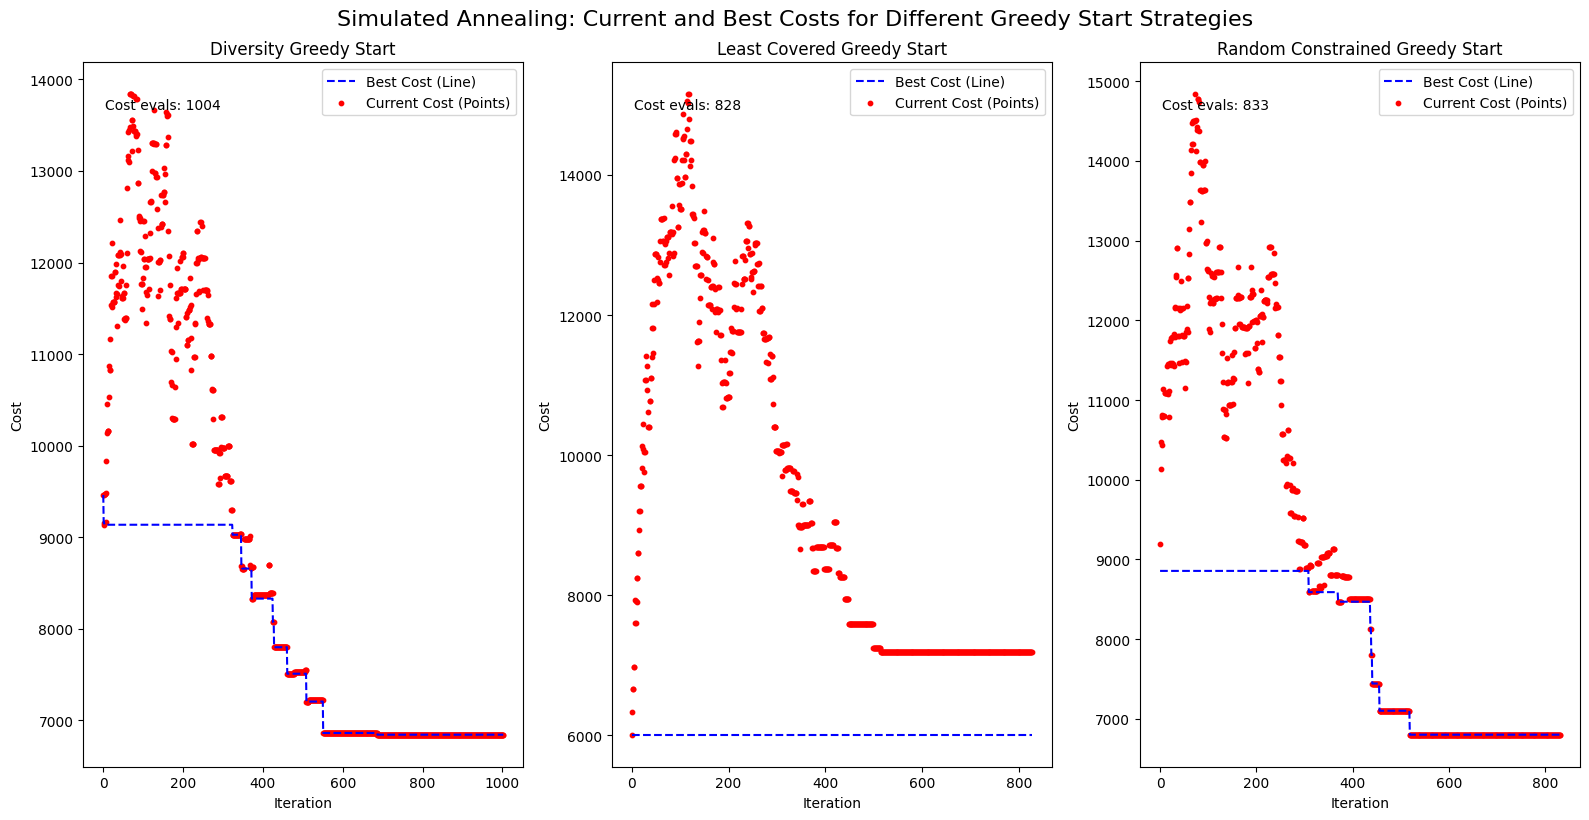

In [218]:
def plot_costs(current_costs, best_costs, title):
    iterations = range(len(current_costs))
    
    plt.figure(figsize=(10, 6))
    
    # Plot best costs as a line
    plt.plot(iterations, best_costs, label="Best Cost (Line)", color='blue')
    
    # Plot current costs as points
    plt.scatter(iterations, current_costs, label="Current Cost (Points)", color='red', s=10)
    
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()
    plt.show()

 

results = []

# Run with diversity-based greedy start
print("Running with diversity-based greedy start...")
initial_solution_diversity = diversity_greedy_start()
best_solution_diversity, best_cost_diversity, best_fitness_diversity, cost_checks_diversity, current_costs_diversity, best_costs_diversity = simulated_annealing_with_advanced_tweak(
    initial_solution_diversity, valid, cost, fitness
)
results.append(("Diversity Greedy Start", best_cost_diversity, current_costs_diversity, best_costs_diversity, cost_checks_diversity))

# Run with least-covered greedy start
print("Running with least-covered greedy start...")
initial_solution_least = least_covered_greedy_start()
best_solution_least, best_cost_least, best_fitness_least, cost_checks_least, current_costs_least, best_costs_least = simulated_annealing_with_advanced_tweak(
    initial_solution_least, valid, cost, fitness
)
results.append(("Least Covered Greedy Start", best_cost_least, current_costs_least, best_costs_least, cost_checks_least))

# Run with random constrained greedy start
print("Running with random constrained greedy start...")
initial_solution_random = random_constrained_greedy_start()
best_solution_random, best_cost_random, best_fitness_random, cost_checks_random, current_costs_random, best_costs_random = simulated_annealing_with_advanced_tweak(
    initial_solution_random, valid, cost, fitness
)
results.append(("Random Constrained Greedy Start", best_cost_random, current_costs_random, best_costs_random, cost_checks_random))


# Plot results for each approach
plt.figure(figsize=(16, 8))

for i, (name, best_cost, current_costs, best_costs, cost_checks) in enumerate(results):
    iterations = range(len(current_costs))
    
    plt.subplot(1, 3, i + 1)  # Create a subplot for each approach
    
    # Plot best costs as a line
    plt.plot(iterations, best_costs, label="Best Cost (Line)", color="blue", linestyle='--')
    
    # Plot current costs as points
    plt.scatter(iterations, current_costs, label="Current Cost (Points)", color="red", s=10)  # Use scatter plot for points
    
    # Add titles and labels
    plt.title(f"{name}")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()

    # Annotate with number of cost checks
    plt.text(0.05, 0.95, f"Cost evals: {cost_checks}", transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top')

plt.tight_layout()
plt.suptitle("Simulated Annealing: Current and Best Costs for Different Greedy Start Strategies", y=1.02, fontsize=16)
plt.show()


In [219]:
#"dumber" algorithm, basically the prevoius version of the one above, it loops a bit more, but may find more deeper solution that might get blocked by the higher cooling rate ecc of the previous algorithm




In [220]:
def fitness(solution, valid, cost):
    """Evaluate the fitness of the solution."""
    if not valid(solution):
        return float('inf')
    return 1 / (1 + cost(solution))


def advanced_tweak(solution):
    #Tweak the current solution by randomly flipping the inclusion of a set.
    tweaked_solution = np.copy(solution)
    flip_index = np.random.randint(0, len(tweaked_solution))
    tweaked_solution[flip_index] = not tweaked_solution[flip_index]
    return tweaked_solution


def simulated_annealing_with_dumb_tweak(initial_solution, valid, cost, fitness, 
                                            max_iterations=10000, initial_temp=1000, cooling_rate=0.995):
    current_solution = initial_solution
    if not valid(current_solution):
        print("Warning: Initial solution is not valid!")
    
    current_cost = cost(current_solution)
    current_fitness = fitness(current_solution, valid, cost)
    
    best_solution = np.copy(current_solution)
    best_cost = current_cost
    best_fitness = current_fitness
    temperature = initial_temp
    
    print("Starting simulated annealing with advanced tweak")
    print(f"Initial cost: {current_cost}, fitness: {current_fitness}")
    
    cost_checks = 1
    current_costs = [current_cost]  # Store the current cost at each iteration
    
    for iteration in range(max_iterations):
        neighbor_solution = advanced_tweak(current_solution)
        
        if valid(neighbor_solution):
            neighbor_cost = cost(neighbor_solution)
            neighbor_fitness = fitness(neighbor_solution, valid, cost)
            cost_checks += 1
            
            if neighbor_cost < current_cost or np.random.rand() < np.exp((current_cost - neighbor_cost) / temperature):
                current_solution = neighbor_solution
                current_cost = neighbor_cost
                current_fitness = neighbor_fitness
                
                if neighbor_cost < best_cost:
                    best_solution = neighbor_solution
                    best_cost = neighbor_cost
                    best_fitness = neighbor_fitness

        temperature *= cooling_rate
        current_costs.append(current_cost)  # Track the current cost
        
        print(f"Iteration {iteration}: Current cost: {current_cost}, Best cost: {best_cost}, Temperature: {temperature}")
        
        if temperature < 1e-6:
            print("Stopping early, temperature too low")
            break
    
    print(f"Total number of cost checks: {cost_checks}")
    
    # Ensure we return all five expected values
    return best_solution, best_cost, best_fitness, cost_checks, current_costs


def diversity_greedy_start():
    """Greedy start function to find an interesting starting solution by maximizing set diversity."""
    selected_sets = []
    covered = np.zeros(UNIVERSE_SIZE, dtype=bool)
    
    # Randomly pick an initial set to start with
    first_set = np.random.randint(len(SETS))
    selected_sets.append(first_set)
    covered = np.logical_or(covered, SETS[first_set])
    
    # Continue selecting sets that maximize diversity (i.e., add the most new elements)
    while not np.all(covered):
        # Score each set by how many uncovered elements it introduces
        uncovered_elements = ~covered
        uncovered_weights = np.dot(SETS, uncovered_elements)
        
        # Select the set that covers the most uncovered elements
        best_set = np.argmax(uncovered_weights)
        selected_sets.append(best_set)
        
        # Update the covered elements
        covered = np.logical_or(covered, SETS[best_set])
    
    # Generate a solution from the selected sets
    initial_solution = np.zeros(len(SETS), dtype=bool)
    for s in selected_sets:
        initial_solution[s] = True
    
    return initial_solution




def least_covered_greedy_start():
    """Greedy start function to find a solution by selecting sets that cover the least-covered elements."""
    selected_sets = []
    covered = np.zeros(UNIVERSE_SIZE, dtype=bool)
    element_cover_count = np.zeros(UNIVERSE_SIZE, dtype=int)
    
    # Continue selecting sets until all elements are covered
    while not np.all(covered):
        # For each set, calculate the sum of how rarely each element in that set is covered
        uncovered_elements = ~covered
        set_scores = np.dot(SETS, uncovered_elements / (1 + element_cover_count))
        
        # Select the set that covers the most uncovered and least-covered elements
        best_set = np.argmax(set_scores)
        selected_sets.append(best_set)
        
        # Update the coverage and cover count for elements in the selected set
        element_cover_count[SETS[best_set]] += 1
        covered = np.logical_or(covered, SETS[best_set])
    
    # Generate the solution
    initial_solution = np.zeros(len(SETS), dtype=bool)
    for s in selected_sets:
        initial_solution[s] = True
    
    return initial_solution



def random_constrained_greedy_start():
    """Greedy start function that randomly picks sets while ensuring coverage."""
    selected_sets = []
    covered = np.zeros(UNIVERSE_SIZE, dtype=bool)
    
    # Continue randomly picking sets that contribute new coverage
    while not np.all(covered):
        available_sets = np.where(np.dot(SETS, ~covered) > 0)[0]
        selected_set = np.random.choice(available_sets)
        selected_sets.append(selected_set)
        covered = np.logical_or(covered, SETS[selected_set])
    
    # Generate the solution
    initial_solution = np.zeros(len(SETS), dtype=bool)
    for s in selected_sets:
        initial_solution[s] = True
    
    return initial_solution

Running with diversity-based greedy start...
Starting simulated annealing with advanced tweak
Initial cost: 9804.898636861642, fitness: 0.0001019794347293037
Iteration 0: Current cost: 9493.089453916318, Best cost: 9493.089453916318, Temperature: 995.0
Iteration 1: Current cost: 9192.386057060527, Best cost: 9192.386057060527, Temperature: 990.025
Iteration 2: Current cost: 9192.386057060527, Best cost: 9192.386057060527, Temperature: 985.074875
Iteration 3: Current cost: 9192.386057060527, Best cost: 9192.386057060527, Temperature: 980.149500625
Iteration 4: Current cost: 9532.115349987376, Best cost: 9192.386057060527, Temperature: 975.248753121875
Iteration 5: Current cost: 9892.453878591039, Best cost: 9192.386057060527, Temperature: 970.3725093562656
Iteration 6: Current cost: 10193.15727544683, Best cost: 9192.386057060527, Temperature: 965.5206468094842
Iteration 7: Current cost: 9815.876262962305, Best cost: 9192.386057060527, Temperature: 960.6930435754368
Iteration 8: Current

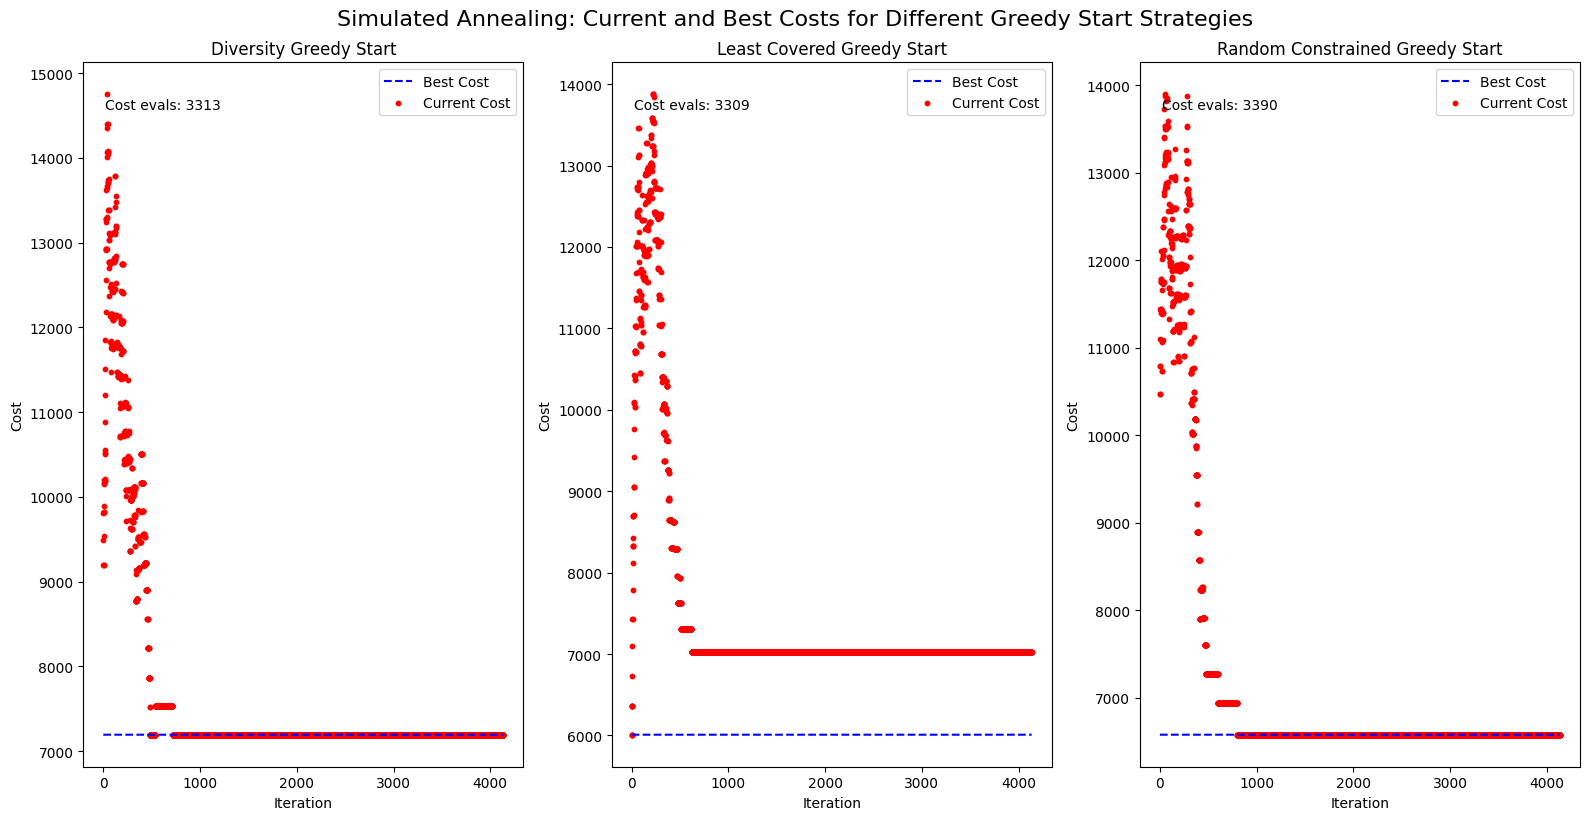

In [221]:
results = []

# Run with diversity-based greedy start
print("Running with diversity-based greedy start...")
initial_solution_diversity = diversity_greedy_start()
best_solution_diversity, best_cost_diversity, best_fitness_diversity, cost_checks_diversity, current_costs_diversity = simulated_annealing_with_dumb_tweak(
    initial_solution_diversity, valid, cost, fitness
)
results.append(("Diversity Greedy Start", best_cost_diversity, current_costs_diversity, cost_checks_diversity))

# Run with least-covered greedy start
print("Running with least-covered greedy start...")
initial_solution_least = least_covered_greedy_start()
best_solution_least, best_cost_least, best_fitness_least, cost_checks_least, current_costs_least = simulated_annealing_with_dumb_tweak(
    initial_solution_least, valid, cost, fitness
)
results.append(("Least Covered Greedy Start", best_cost_least, current_costs_least, cost_checks_least))

# Run with random constrained greedy start
print("Running with random constrained greedy start...")
initial_solution_random = random_constrained_greedy_start()
best_solution_random, best_cost_random, best_fitness_random, cost_checks_random, current_costs_random = simulated_annealing_with_dumb_tweak(
    initial_solution_random, valid, cost, fitness
)
results.append(("Random Constrained Greedy Start", best_cost_random, current_costs_random, cost_checks_random))


# Plot results for each approach
plt.figure(figsize=(16, 8))

for i, (name, best_cost, current_costs, cost_checks) in enumerate(results):
    iterations = range(len(current_costs))
    
    plt.subplot(1, 3, i + 1)  # Create a subplot for each approach
    
    # Plot best cost as a horizontal line
    plt.plot(iterations, [best_cost] * len(current_costs), label="Best Cost", color="blue", linestyle='--')
    
    # Plot current costs as points
    plt.scatter(iterations, current_costs, label="Current Cost", color="red", s=10)  # Use scatter plot for points
    
    # Add titles and labels
    plt.title(f"{name}")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()

    # Annotate with number of cost checks
    plt.text(0.05, 0.95, f"Cost evals: {cost_checks}", transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top')

plt.tight_layout()
plt.suptitle("Simulated Annealing: Current and Best Costs for Different Greedy Start Strategies", y=1.02, fontsize=16)
plt.show()